In [ ]:
!pip install -U --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 30.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing i

In [ ]:
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print(f"train samples: {len(os.listdir('/content/drive/MyDrive/COEP/train_sample_videos'))}")

Mounted at /content/drive
train samples: 402


In [ ]:
train_sample_metadata = pd.read_json('/content/drive/MyDrive/COEP/train_sample_videos/metadata1.json').T
train_sample_metadata.head()

,label,split,original
abarnvbtwb.mp4,REAL,train,None
aelfnikyqj.mp4,REAL,train,None
afoovlsmtx.mp4,REAL,train,None
agrmhtjdlk.mp4,REAL,train,None
ahqqqilsxt.mp4,REAL,train,None


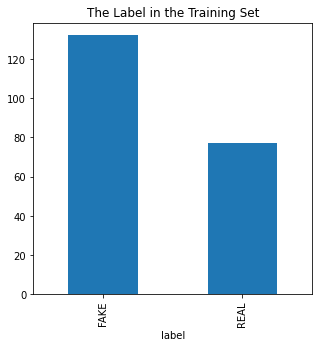

In [ ]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(5,5),kind='bar',title='The Label in the Training Set')
plt.show()

In [ ]:
def capture_image_from_video(video_path):
    capture_image = cv2.VideoCapture(video_path)
    ret, frame = capture_image.read()
    fig = plt.figure(figsize =(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

In [ ]:
r_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='REAL'].sample(5).index)
r_train_sample_video

['dhxctgyoqj.mp4',
 'abarnvbtwb.mp4',
 'bpapbctoao.mp4',
 'erlvuvjsjf.mp4',
 'bejhvclboh.mp4']

In [ ]:
img_size = 224
batch_size = 64
epochs = 5

max_seq_length = 20
num_features = 2048

In [ ]:
def crop_center_square(frame):
    y,x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y :start_y + min_dim, start_x : start_x + min_dim]


In [ ]:
def load_video(path, max_frames=0, resize=(img_size, img_size)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while 1:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def pretrain_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
    weights = "imagenet",
    include_top=False,
    pooling="avg",
    input_shape = (img_size,img_size,3)
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    
    inputs = keras.Input((img_size,img_size,3))
    preprocessed = preprocess_input(inputs)
    
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = pretrain_feature_extractor()

In [ ]:
def prepare_all_videos(df, root_dir): #df是train_sample_metadata->json的split
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels=='FAKE').astype(np.int)
    
    frame_masks = np.zeros(shape=(num_samples, max_seq_length), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, max_seq_length, num_features), dtype="float32"
    )
    
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        
        temp_frame_mask = np.zeros(shape=(1, max_seq_length,), dtype="bool")
        temp_frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")
        
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(max_seq_length, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] =feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] =1 # 1 = not masked, 0 = masked
        
        frame_features[idx,] =temp_frame_features.squeeze()
        frame_masks[idx,] =temp_frame_mask.squeeze()
    
    return (frame_features, frame_masks), labels

In [ ]:
from sklearn.model_selection import train_test_split
def train_model():
  Train_set,Test_set = train_test_split(train_sample_metadata, test_size=0.2,random_state=None,stratify=train_sample_metadata['label'])
  print(Train_set.shape, Test_set.shape)
  train_data, train_labels = prepare_all_videos(Train_set, "train")
  test_data, test_labels = prepare_all_videos(Test_set, "test")
  frame_features_input = keras.Input((max_seq_length, num_features))
  mask_input = keras.Input((max_seq_length,),dtype="bool")
  x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask = mask_input)
  x = keras.layers.GRU(8)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(8, activation="relu")(x)
  output = keras.layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model([frame_features_input, mask_input], output)
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.summary()

  checkpoint = keras.callbacks.ModelCheckpoint('./', save_weights_only=True, save_best_only=True)
  history = model.fit(
          [train_data[0], train_data[1]],
          train_labels,
          validation_data=([test_data[0], test_data[1]], test_labels),
          callbacks=[checkpoint],
          epochs=epochs,
          batch_size=8
  )
  return model

In [ ]:
model=train_model()
for i in range(100):
  model=train_model()

(167, 3) (42, 3)


<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_10 (GRU)                   (None, 20, 16)       99168       ['input_15[0][0]',               
                                                                  'input_16[0][0]']               
                                                                                                  
 gru_11 (GRU)                   (None, 8)            624         ['gru_10[0][0]']           

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_12 (GRU)                   (None, 20, 16)       99168       ['input_17[0][0]',               
                                                                  'input_18[0][0]']               
                                                                                                  
 gru_13 (GRU)                   (None, 8)            624         ['gru_12[0][0]']           

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_14 (GRU)                   (None, 20, 16)       99168       ['input_19[0][0]',               
                                                                  'input_20[0][0]']               
                                                                                                  
 gru_15 (GRU)                   (None, 8)            624         ['gru_14[0][0]']           

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_16 (GRU)                   (None, 20, 16)       99168       ['input_21[0][0]',               
                                                                  'input_22[0][0]']               
                                                                                                  
 gru_17 (GRU)                   (None, 8)            624         ['gru_16[0][0]']           

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_18 (GRU)                   (None, 20, 16)       99168       ['input_23[0][0]',               
                                                                  'input_24[0][0]']               
                                                                                                  
 gru_19 (GRU)                   (None, 8)            624         ['gru_18[0][0]']           

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_20 (GRU)                   (None, 20, 16)       99168       ['input_25[0][0]',               
                                                                  'input_26[0][0]']               
                                                                                                  
 gru_21 (GRU)                   (None, 8)            624         ['gru_20[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_22 (GRU)                   (None, 20, 16)       99168       ['input_27[0][0]',               
                                                                  'input_28[0][0]']               
                                                                                                  
 gru_23 (GRU)                   (None, 8)            624         ['gru_22[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_24 (GRU)                   (None, 20, 16)       99168       ['input_29[0][0]',               
                                                                  'input_30[0][0]']               
                                                                                                  
 gru_25 (GRU)                   (None, 8)            624         ['gru_24[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_26 (GRU)                   (None, 20, 16)       99168       ['input_31[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 gru_27 (GRU)                   (None, 8)            624         ['gru_26[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_28 (GRU)                   (None, 20, 16)       99168       ['input_33[0][0]',               
                                                                  'input_34[0][0]']               
                                                                                                  
 gru_29 (GRU)                   (None, 8)            624         ['gru_28[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_30 (GRU)                   (None, 20, 16)       99168       ['input_35[0][0]',               
                                                                  'input_36[0][0]']               
                                                                                                  
 gru_31 (GRU)                   (None, 8)            624         ['gru_30[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_32 (GRU)                   (None, 20, 16)       99168       ['input_37[0][0]',               
                                                                  'input_38[0][0]']               
                                                                                                  
 gru_33 (GRU)                   (None, 8)            624         ['gru_32[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_34 (GRU)                   (None, 20, 16)       99168       ['input_39[0][0]',               
                                                                  'input_40[0][0]']               
                                                                                                  
 gru_35 (GRU)                   (None, 8)            624         ['gru_34[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_36 (GRU)                   (None, 20, 16)       99168       ['input_41[0][0]',               
                                                                  'input_42[0][0]']               
                                                                                                  
 gru_37 (GRU)                   (None, 8)            624         ['gru_36[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_38 (GRU)                   (None, 20, 16)       99168       ['input_43[0][0]',               
                                                                  'input_44[0][0]']               
                                                                                                  
 gru_39 (GRU)                   (None, 8)            624         ['gru_38[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_40 (GRU)                   (None, 20, 16)       99168       ['input_45[0][0]',               
                                                                  'input_46[0][0]']               
                                                                                                  
 gru_41 (GRU)                   (None, 8)            624         ['gru_40[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_42 (GRU)                   (None, 20, 16)       99168       ['input_47[0][0]',               
                                                                  'input_48[0][0]']               
                                                                                                  
 gru_43 (GRU)                   (None, 8)            624         ['gru_42[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_44 (GRU)                   (None, 20, 16)       99168       ['input_49[0][0]',               
                                                                  'input_50[0][0]']               
                                                                                                  
 gru_45 (GRU)                   (None, 8)            624         ['gru_44[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_52 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_46 (GRU)                   (None, 20, 16)       99168       ['input_51[0][0]',               
                                                                  'input_52[0][0]']               
                                                                                                  
 gru_47 (GRU)                   (None, 8)            624         ['gru_46[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_48 (GRU)                   (None, 20, 16)       99168       ['input_53[0][0]',               
                                                                  'input_54[0][0]']               
                                                                                                  
 gru_49 (GRU)                   (None, 8)            624         ['gru_48[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_56 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_50 (GRU)                   (None, 20, 16)       99168       ['input_55[0][0]',               
                                                                  'input_56[0][0]']               
                                                                                                  
 gru_51 (GRU)                   (None, 8)            624         ['gru_50[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_58 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_52 (GRU)                   (None, 20, 16)       99168       ['input_57[0][0]',               
                                                                  'input_58[0][0]']               
                                                                                                  
 gru_53 (GRU)                   (None, 8)            624         ['gru_52[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_60 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_54 (GRU)                   (None, 20, 16)       99168       ['input_59[0][0]',               
                                                                  'input_60[0][0]']               
                                                                                                  
 gru_55 (GRU)                   (None, 8)            624         ['gru_54[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_62 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_56 (GRU)                   (None, 20, 16)       99168       ['input_61[0][0]',               
                                                                  'input_62[0][0]']               
                                                                                                  
 gru_57 (GRU)                   (None, 8)            624         ['gru_56[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_63 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_64 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_58 (GRU)                   (None, 20, 16)       99168       ['input_63[0][0]',               
                                                                  'input_64[0][0]']               
                                                                                                  
 gru_59 (GRU)                   (None, 8)            624         ['gru_58[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_66 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_60 (GRU)                   (None, 20, 16)       99168       ['input_65[0][0]',               
                                                                  'input_66[0][0]']               
                                                                                                  
 gru_61 (GRU)                   (None, 8)            624         ['gru_60[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_67 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_68 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_62 (GRU)                   (None, 20, 16)       99168       ['input_67[0][0]',               
                                                                  'input_68[0][0]']               
                                                                                                  
 gru_63 (GRU)                   (None, 8)            624         ['gru_62[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_70 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_64 (GRU)                   (None, 20, 16)       99168       ['input_69[0][0]',               
                                                                  'input_70[0][0]']               
                                                                                                  
 gru_65 (GRU)                   (None, 8)            624         ['gru_64[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_71 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_72 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_66 (GRU)                   (None, 20, 16)       99168       ['input_71[0][0]',               
                                                                  'input_72[0][0]']               
                                                                                                  
 gru_67 (GRU)                   (None, 8)            624         ['gru_66[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_74 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_68 (GRU)                   (None, 20, 16)       99168       ['input_73[0][0]',               
                                                                  'input_74[0][0]']               
                                                                                                  
 gru_69 (GRU)                   (None, 8)            624         ['gru_68[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_76 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_70 (GRU)                   (None, 20, 16)       99168       ['input_75[0][0]',               
                                                                  'input_76[0][0]']               
                                                                                                  
 gru_71 (GRU)                   (None, 8)            624         ['gru_70[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_77 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_78 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_72 (GRU)                   (None, 20, 16)       99168       ['input_77[0][0]',               
                                                                  'input_78[0][0]']               
                                                                                                  
 gru_73 (GRU)                   (None, 8)            624         ['gru_72[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_79 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_80 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_74 (GRU)                   (None, 20, 16)       99168       ['input_79[0][0]',               
                                                                  'input_80[0][0]']               
                                                                                                  
 gru_75 (GRU)                   (None, 8)            624         ['gru_74[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_82 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_76 (GRU)                   (None, 20, 16)       99168       ['input_81[0][0]',               
                                                                  'input_82[0][0]']               
                                                                                                  
 gru_77 (GRU)                   (None, 8)            624         ['gru_76[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_83 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_84 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_78 (GRU)                   (None, 20, 16)       99168       ['input_83[0][0]',               
                                                                  'input_84[0][0]']               
                                                                                                  
 gru_79 (GRU)                   (None, 8)            624         ['gru_78[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_85 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_86 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_80 (GRU)                   (None, 20, 16)       99168       ['input_85[0][0]',               
                                                                  'input_86[0][0]']               
                                                                                                  
 gru_81 (GRU)                   (None, 8)            624         ['gru_80[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_87 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_88 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_82 (GRU)                   (None, 20, 16)       99168       ['input_87[0][0]',               
                                                                  'input_88[0][0]']               
                                                                                                  
 gru_83 (GRU)                   (None, 8)            624         ['gru_82[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_89 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_90 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_84 (GRU)                   (None, 20, 16)       99168       ['input_89[0][0]',               
                                                                  'input_90[0][0]']               
                                                                                                  
 gru_85 (GRU)                   (None, 8)            624         ['gru_84[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_91 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_92 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_86 (GRU)                   (None, 20, 16)       99168       ['input_91[0][0]',               
                                                                  'input_92[0][0]']               
                                                                                                  
 gru_87 (GRU)                   (None, 8)            624         ['gru_86[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_93 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_94 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_88 (GRU)                   (None, 20, 16)       99168       ['input_93[0][0]',               
                                                                  'input_94[0][0]']               
                                                                                                  
 gru_89 (GRU)                   (None, 8)            624         ['gru_88[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_95 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_96 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_90 (GRU)                   (None, 20, 16)       99168       ['input_95[0][0]',               
                                                                  'input_96[0][0]']               
                                                                                                  
 gru_91 (GRU)                   (None, 8)            624         ['gru_90[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_97 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_98 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 gru_92 (GRU)                   (None, 20, 16)       99168       ['input_97[0][0]',               
                                                                  'input_98[0][0]']               
                                                                                                  
 gru_93 (GRU)                   (None, 8)            624         ['gru_92[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_99 (InputLayer)          [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_100 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_94 (GRU)                   (None, 20, 16)       99168       ['input_99[0][0]',               
                                                                  'input_100[0][0]']              
                                                                                                  
 gru_95 (GRU)                   (None, 8)            624         ['gru_94[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_101 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_102 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_96 (GRU)                   (None, 20, 16)       99168       ['input_101[0][0]',              
                                                                  'input_102[0][0]']              
                                                                                                  
 gru_97 (GRU)                   (None, 8)            624         ['gru_96[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_49"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_103 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_104 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_98 (GRU)                   (None, 20, 16)       99168       ['input_103[0][0]',              
                                                                  'input_104[0][0]']              
                                                                                                  
 gru_99 (GRU)                   (None, 8)            624         ['gru_98[0][0]']          

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_105 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_106 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_100 (GRU)                  (None, 20, 16)       99168       ['input_105[0][0]',              
                                                                  'input_106[0][0]']              
                                                                                                  
 gru_101 (GRU)                  (None, 8)            624         ['gru_100[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_107 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_108 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_102 (GRU)                  (None, 20, 16)       99168       ['input_107[0][0]',              
                                                                  'input_108[0][0]']              
                                                                                                  
 gru_103 (GRU)                  (None, 8)            624         ['gru_102[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_109 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_110 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_104 (GRU)                  (None, 20, 16)       99168       ['input_109[0][0]',              
                                                                  'input_110[0][0]']              
                                                                                                  
 gru_105 (GRU)                  (None, 8)            624         ['gru_104[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_111 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_112 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_106 (GRU)                  (None, 20, 16)       99168       ['input_111[0][0]',              
                                                                  'input_112[0][0]']              
                                                                                                  
 gru_107 (GRU)                  (None, 8)            624         ['gru_106[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_113 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_114 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_108 (GRU)                  (None, 20, 16)       99168       ['input_113[0][0]',              
                                                                  'input_114[0][0]']              
                                                                                                  
 gru_109 (GRU)                  (None, 8)            624         ['gru_108[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_55"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_115 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_116 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_110 (GRU)                  (None, 20, 16)       99168       ['input_115[0][0]',              
                                                                  'input_116[0][0]']              
                                                                                                  
 gru_111 (GRU)                  (None, 8)            624         ['gru_110[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_117 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_118 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_112 (GRU)                  (None, 20, 16)       99168       ['input_117[0][0]',              
                                                                  'input_118[0][0]']              
                                                                                                  
 gru_113 (GRU)                  (None, 8)            624         ['gru_112[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_57"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_119 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_120 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_114 (GRU)                  (None, 20, 16)       99168       ['input_119[0][0]',              
                                                                  'input_120[0][0]']              
                                                                                                  
 gru_115 (GRU)                  (None, 8)            624         ['gru_114[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_58"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_121 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_122 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_116 (GRU)                  (None, 20, 16)       99168       ['input_121[0][0]',              
                                                                  'input_122[0][0]']              
                                                                                                  
 gru_117 (GRU)                  (None, 8)            624         ['gru_116[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_59"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_123 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_124 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_118 (GRU)                  (None, 20, 16)       99168       ['input_123[0][0]',              
                                                                  'input_124[0][0]']              
                                                                                                  
 gru_119 (GRU)                  (None, 8)            624         ['gru_118[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_125 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_126 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_120 (GRU)                  (None, 20, 16)       99168       ['input_125[0][0]',              
                                                                  'input_126[0][0]']              
                                                                                                  
 gru_121 (GRU)                  (None, 8)            624         ['gru_120[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_61"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_127 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_128 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_122 (GRU)                  (None, 20, 16)       99168       ['input_127[0][0]',              
                                                                  'input_128[0][0]']              
                                                                                                  
 gru_123 (GRU)                  (None, 8)            624         ['gru_122[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_62"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_129 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_130 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_124 (GRU)                  (None, 20, 16)       99168       ['input_129[0][0]',              
                                                                  'input_130[0][0]']              
                                                                                                  
 gru_125 (GRU)                  (None, 8)            624         ['gru_124[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_63"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_131 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_132 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_126 (GRU)                  (None, 20, 16)       99168       ['input_131[0][0]',              
                                                                  'input_132[0][0]']              
                                                                                                  
 gru_127 (GRU)                  (None, 8)            624         ['gru_126[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_64"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_133 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_134 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_128 (GRU)                  (None, 20, 16)       99168       ['input_133[0][0]',              
                                                                  'input_134[0][0]']              
                                                                                                  
 gru_129 (GRU)                  (None, 8)            624         ['gru_128[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_65"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_135 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_136 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_130 (GRU)                  (None, 20, 16)       99168       ['input_135[0][0]',              
                                                                  'input_136[0][0]']              
                                                                                                  
 gru_131 (GRU)                  (None, 8)            624         ['gru_130[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_66"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_137 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_138 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_132 (GRU)                  (None, 20, 16)       99168       ['input_137[0][0]',              
                                                                  'input_138[0][0]']              
                                                                                                  
 gru_133 (GRU)                  (None, 8)            624         ['gru_132[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_139 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_140 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_134 (GRU)                  (None, 20, 16)       99168       ['input_139[0][0]',              
                                                                  'input_140[0][0]']              
                                                                                                  
 gru_135 (GRU)                  (None, 8)            624         ['gru_134[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_141 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_142 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_136 (GRU)                  (None, 20, 16)       99168       ['input_141[0][0]',              
                                                                  'input_142[0][0]']              
                                                                                                  
 gru_137 (GRU)                  (None, 8)            624         ['gru_136[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_69"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_143 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_144 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_138 (GRU)                  (None, 20, 16)       99168       ['input_143[0][0]',              
                                                                  'input_144[0][0]']              
                                                                                                  
 gru_139 (GRU)                  (None, 8)            624         ['gru_138[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_70"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_145 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_146 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_140 (GRU)                  (None, 20, 16)       99168       ['input_145[0][0]',              
                                                                  'input_146[0][0]']              
                                                                                                  
 gru_141 (GRU)                  (None, 8)            624         ['gru_140[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_71"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_147 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_148 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_142 (GRU)                  (None, 20, 16)       99168       ['input_147[0][0]',              
                                                                  'input_148[0][0]']              
                                                                                                  
 gru_143 (GRU)                  (None, 8)            624         ['gru_142[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_72"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_149 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_150 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_144 (GRU)                  (None, 20, 16)       99168       ['input_149[0][0]',              
                                                                  'input_150[0][0]']              
                                                                                                  
 gru_145 (GRU)                  (None, 8)            624         ['gru_144[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_73"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_151 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_152 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_146 (GRU)                  (None, 20, 16)       99168       ['input_151[0][0]',              
                                                                  'input_152[0][0]']              
                                                                                                  
 gru_147 (GRU)                  (None, 8)            624         ['gru_146[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_74"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_153 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_154 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_148 (GRU)                  (None, 20, 16)       99168       ['input_153[0][0]',              
                                                                  'input_154[0][0]']              
                                                                                                  
 gru_149 (GRU)                  (None, 8)            624         ['gru_148[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_75"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_155 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_156 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_150 (GRU)                  (None, 20, 16)       99168       ['input_155[0][0]',              
                                                                  'input_156[0][0]']              
                                                                                                  
 gru_151 (GRU)                  (None, 8)            624         ['gru_150[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_76"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_157 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_158 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_152 (GRU)                  (None, 20, 16)       99168       ['input_157[0][0]',              
                                                                  'input_158[0][0]']              
                                                                                                  
 gru_153 (GRU)                  (None, 8)            624         ['gru_152[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_77"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_159 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_160 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_154 (GRU)                  (None, 20, 16)       99168       ['input_159[0][0]',              
                                                                  'input_160[0][0]']              
                                                                                                  
 gru_155 (GRU)                  (None, 8)            624         ['gru_154[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_78"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_161 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_162 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_156 (GRU)                  (None, 20, 16)       99168       ['input_161[0][0]',              
                                                                  'input_162[0][0]']              
                                                                                                  
 gru_157 (GRU)                  (None, 8)            624         ['gru_156[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_79"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_163 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_164 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_158 (GRU)                  (None, 20, 16)       99168       ['input_163[0][0]',              
                                                                  'input_164[0][0]']              
                                                                                                  
 gru_159 (GRU)                  (None, 8)            624         ['gru_158[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_80"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_165 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_166 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_160 (GRU)                  (None, 20, 16)       99168       ['input_165[0][0]',              
                                                                  'input_166[0][0]']              
                                                                                                  
 gru_161 (GRU)                  (None, 8)            624         ['gru_160[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_81"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_167 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_168 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_162 (GRU)                  (None, 20, 16)       99168       ['input_167[0][0]',              
                                                                  'input_168[0][0]']              
                                                                                                  
 gru_163 (GRU)                  (None, 8)            624         ['gru_162[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_82"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_169 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_170 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_164 (GRU)                  (None, 20, 16)       99168       ['input_169[0][0]',              
                                                                  'input_170[0][0]']              
                                                                                                  
 gru_165 (GRU)                  (None, 8)            624         ['gru_164[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_83"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_171 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_172 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_166 (GRU)                  (None, 20, 16)       99168       ['input_171[0][0]',              
                                                                  'input_172[0][0]']              
                                                                                                  
 gru_167 (GRU)                  (None, 8)            624         ['gru_166[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_84"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_173 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_174 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_168 (GRU)                  (None, 20, 16)       99168       ['input_173[0][0]',              
                                                                  'input_174[0][0]']              
                                                                                                  
 gru_169 (GRU)                  (None, 8)            624         ['gru_168[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_85"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_175 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_176 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_170 (GRU)                  (None, 20, 16)       99168       ['input_175[0][0]',              
                                                                  'input_176[0][0]']              
                                                                                                  
 gru_171 (GRU)                  (None, 8)            624         ['gru_170[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_86"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_177 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_178 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_172 (GRU)                  (None, 20, 16)       99168       ['input_177[0][0]',              
                                                                  'input_178[0][0]']              
                                                                                                  
 gru_173 (GRU)                  (None, 8)            624         ['gru_172[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_87"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_179 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_180 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_174 (GRU)                  (None, 20, 16)       99168       ['input_179[0][0]',              
                                                                  'input_180[0][0]']              
                                                                                                  
 gru_175 (GRU)                  (None, 8)            624         ['gru_174[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_88"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_181 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_182 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_176 (GRU)                  (None, 20, 16)       99168       ['input_181[0][0]',              
                                                                  'input_182[0][0]']              
                                                                                                  
 gru_177 (GRU)                  (None, 8)            624         ['gru_176[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_89"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_183 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_184 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_178 (GRU)                  (None, 20, 16)       99168       ['input_183[0][0]',              
                                                                  'input_184[0][0]']              
                                                                                                  
 gru_179 (GRU)                  (None, 8)            624         ['gru_178[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_90"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_185 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_186 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_180 (GRU)                  (None, 20, 16)       99168       ['input_185[0][0]',              
                                                                  'input_186[0][0]']              
                                                                                                  
 gru_181 (GRU)                  (None, 8)            624         ['gru_180[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_91"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_187 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_188 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_182 (GRU)                  (None, 20, 16)       99168       ['input_187[0][0]',              
                                                                  'input_188[0][0]']              
                                                                                                  
 gru_183 (GRU)                  (None, 8)            624         ['gru_182[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_92"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_189 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_190 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_184 (GRU)                  (None, 20, 16)       99168       ['input_189[0][0]',              
                                                                  'input_190[0][0]']              
                                                                                                  
 gru_185 (GRU)                  (None, 8)            624         ['gru_184[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_93"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_191 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_192 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_186 (GRU)                  (None, 20, 16)       99168       ['input_191[0][0]',              
                                                                  'input_192[0][0]']              
                                                                                                  
 gru_187 (GRU)                  (None, 8)            624         ['gru_186[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_94"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_193 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_194 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_188 (GRU)                  (None, 20, 16)       99168       ['input_193[0][0]',              
                                                                  'input_194[0][0]']              
                                                                                                  
 gru_189 (GRU)                  (None, 8)            624         ['gru_188[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_95"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_195 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_196 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_190 (GRU)                  (None, 20, 16)       99168       ['input_195[0][0]',              
                                                                  'input_196[0][0]']              
                                                                                                  
 gru_191 (GRU)                  (None, 8)            624         ['gru_190[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_197 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_198 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_192 (GRU)                  (None, 20, 16)       99168       ['input_197[0][0]',              
                                                                  'input_198[0][0]']              
                                                                                                  
 gru_193 (GRU)                  (None, 8)            624         ['gru_192[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_97"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_199 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_200 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_194 (GRU)                  (None, 20, 16)       99168       ['input_199[0][0]',              
                                                                  'input_200[0][0]']              
                                                                                                  
 gru_195 (GRU)                  (None, 8)            624         ['gru_194[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_98"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_201 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_202 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_196 (GRU)                  (None, 20, 16)       99168       ['input_201[0][0]',              
                                                                  'input_202[0][0]']              
                                                                                                  
 gru_197 (GRU)                  (None, 8)            624         ['gru_196[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_99"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_203 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_204 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_198 (GRU)                  (None, 20, 16)       99168       ['input_203[0][0]',              
                                                                  'input_204[0][0]']              
                                                                                                  
 gru_199 (GRU)                  (None, 8)            624         ['gru_198[0][0]']         

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_100"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_205 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_206 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_200 (GRU)                  (None, 20, 16)       99168       ['input_205[0][0]',              
                                                                  'input_206[0][0]']              
                                                                                                  
 gru_201 (GRU)                  (None, 8)            624         ['gru_200[0][0]']        

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_207 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_208 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_202 (GRU)                  (None, 20, 16)       99168       ['input_207[0][0]',              
                                                                  'input_208[0][0]']              
                                                                                                  
 gru_203 (GRU)                  (None, 8)            624         ['gru_202[0][0]']        

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_102"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_209 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_210 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_204 (GRU)                  (None, 20, 16)       99168       ['input_209[0][0]',              
                                                                  'input_210[0][0]']              
                                                                                                  
 gru_205 (GRU)                  (None, 8)            624         ['gru_204[0][0]']        

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_103"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_211 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_212 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_206 (GRU)                  (None, 20, 16)       99168       ['input_211[0][0]',              
                                                                  'input_212[0][0]']              
                                                                                                  
 gru_207 (GRU)                  (None, 8)            624         ['gru_206[0][0]']        

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_104"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_213 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_214 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_208 (GRU)                  (None, 20, 16)       99168       ['input_213[0][0]',              
                                                                  'input_214[0][0]']              
                                                                                                  
 gru_209 (GRU)                  (None, 8)            624         ['gru_208[0][0]']        

<ipython-input-23-f735ee22819b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Model: "model_105"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_215 (InputLayer)         [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_216 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 gru_210 (GRU)                  (None, 20, 16)       99168       ['input_215[0][0]',              
                                                                  'input_216[0][0]']              
                                                                                                  
 gru_211 (GRU)                  (None, 8)            624         ['gru_210[0][0]']        

In [ ]:
# from sklearn.model_selection import train_test_split

# Train_set , Test_set = train_test_split(train_sample_metadata, test_size=0.2,random_state=None,
#                                        stratify=train_sample_metadata['label'])
# print(Train_set.shape, Test_set.shape)

In [ ]:
# train_data, train_labels = prepare_all_videos(Train_set, "train")
# test_data, test_labels = prepare_all_videos(Test_set, "test")

# print(f"Frame features in train set:{train_data[0].shape}")
# print(f"Frame masks in train set:{train_data[1].shape}")

In [ ]:
# frame_features_input = keras.Input((max_seq_length, num_features))
# mask_input = keras.Input((max_seq_length,),dtype="bool")

# x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask = mask_input)
# x = keras.layers.GRU(8)(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(8, activation="relu")(x)
# output = keras.layers.Dense(1, activation="sigmoid")(x)

# model = keras.Model([frame_features_input, mask_input], output)
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.summary()

In [ ]:
# checkpoint = keras.callbacks.ModelCheckpoint('./', save_weights_only=True, save_best_only=True)
# history = model.fit(
#         [train_data[0], train_data[1]],
#         train_labels,
#         validation_data=([test_data[0], test_data[1]], test_labels),
#         callbacks=[checkpoint],
#         epochs=epochs,
#         batch_size=8
# )

In [ ]:
model.save("model_123")

In [ ]:
model1 = keras.models.load_model('/content/model_123')

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, max_seq_length,), dtype="bool")
    frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(max_seq_length, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model1.predict([frame_features, frame_mask])
    
# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
# def to_gif(images):
#     converted_images = images.astype(np.uint8)
#     imageio.mimsave("animation.gif", converted_images, fps=10)
#     return embed.embed_file("animation.gif")

# test_videos = ["real/1ltY-IMlm1s_00_02_21_00_02_31.mp4","real/1ltY-IMlm1s_00_04_31_00_04_40.mp4","real/3-tSu6I6yT0_00_00_55_00_01_05.mp4","real/3-tSu6I6yT0_00_01_12_00_01_20.mp4","real/3BTgub0Sxno_00_00_30_00_00_40.mp4","real/3BTgub0Sxno_00_00_30_00_00_40.mp4", "real/3OCzdTWpqsg_00_00_40_00_00_50.mp4" ,"real/3jCsZBEuvvw_00_00_24_00_00_34.mp4","real/3qy-oETFBJ4_00_03_00_00_03_10.mp4","real/4HFay7qrr7A_00_03_17_00_03_27.mp4","real/4L_yCwFD6Jo_00_03_43_00_03_53.mp4","real/7Mo4AcWG_OU_00_00_13_00_00_23.mp4" , "real/8Y-SCV1XYFM_00_00_25_00_00_35.mp4","real/8Y-SCV1XYFM_00_00_45_00_00_55.mp4" ,"real/8Y-SCV1XYFM_00_01_34_00_01_44.mp4" , "real/8Y-SCV1XYFM_00_02_33_00_02_43.mp4" , "real/8Y-SCV1XYFM_00_03_20_00_03_30.mp4" , "real/9f0wWZe6xW0_00_00_08_00_00_18.mp4" , "real/_4xMYyFjONI_00_01_14_00_01_24.mp4" , "real/_4xMYyFjONI_00_05_07_00_05_17.mp4" , "real/_v_ZAtc06Jk_00_02_12_00_02_22.mp4"]
test_videos = ["/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_02_21_00_02_31.mp4","/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_04_31_00_04_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_00_55_00_01_05.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_01_12_00_01_20.mp4"]
# test_videos = ["/content/drive/MyDrive/COEP/DATA/fake/1.mp4" , "/content/drive/MyDrive/COEP/DATA/fake/10.mp4" ,"/content/drive/MyDrive/COEP/DATA/fake/11.mp4" ,"/content/drive/MyDrive/COEP/DATA/fake/12.mp4" ,"/content/drive/MyDrive/COEP/DATA/fake/13.mp4" ,"/content/drive/MyDrive/COEP/DATA/fake/14.mp4"]

# play_video(test_video,TEST_FOLDER)

In [ ]:
# test_videos = ["/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_02_21_00_02_31.mp4","/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_04_31_00_04_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_00_55_00_01_05.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_01_12_00_01_20.mp4"]
test_videos = ["/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_02_21_00_02_31.mp4","/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_04_31_00_04_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_00_55_00_01_05.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_01_12_00_01_20.mp4","/content/drive/MyDrive/COEP/DATA/real/3BTgub0Sxno_00_00_30_00_00_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3OCzdTWpqsg_00_00_40_00_00_50.mp4","/content/drive/MyDrive/COEP/DATA/real/3jCsZBEuvvw_00_00_24_00_00_34.mp4","/content/drive/MyDrive/COEP/DATA/real/3qy-oETFBJ4_00_03_00_00_03_10.mp4","/content/drive/MyDrive/COEP/DATA/real/4HFay7qrr7A_00_03_17_00_03_27.mp4","/content/drive/MyDrive/COEP/DATA/real/4L_yCwFD6Jo_00_03_43_00_03_53.mp4","/content/drive/MyDrive/COEP/DATA/real/7Mo4AcWG_OU_00_00_13_00_00_23.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_00_25_00_00_35.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_00_45_00_00_55.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_01_34_00_01_44.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_02_33_00_02_43.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_03_20_00_03_30.mp4","/content/drive/MyDrive/COEP/DATA/real/9f0wWZe6xW0_00_00_08_00_00_18.mp4","/content/drive/MyDrive/COEP/DATA/real/_4xMYyFjONI_00_01_14_00_01_24.mp4","/content/drive/MyDrive/COEP/DATA/real/_4xMYyFjONI_00_05_07_00_05_17.mp4","/content/drive/MyDrive/COEP/DATA/real/_v_ZAtc06Jk_00_02_12_00_02_22.mp4"]
for i in test_videos:
  test_video = i
# test_video = np.random.choice(test_videos["video"].values.tolist())
  print(f"Test video path: {test_video}")
  abc = sequence_prediction(test_video)
  print(abc)
  print(' FAKE',abc)
  print(' REAL',1-abc)


Test video path: /content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_02_21_00_02_31.mp4
1/1 [==============================] - 3s 3s/step
[[0.4525031]]
 FAKE [[0.4525031]]
 REAL [[0.5474969]]
Test video path: /content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_04_31_00_04_40.mp4
1/1 [==============================] - 0s 36ms/step
[[0.45730144]]
 FAKE [[0.45730144]]
 REAL [[0.54269856]]
Test video path: /content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_00_55_00_01_05.mp4
1/1 [==============================] - 0s 32ms/step
[[0.52659225]]
 FAKE [[0.52659225]]
 REAL [[0.47340775]]
Test video path: /content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_01_12_00_01_20.mp4
1/1 [==============================] - 0s 37ms/step
[[0.4813152]]
 FAKE [[0.4813152]]
 REAL [[0.5186848]]
Test video path: /content/drive/MyDrive/COEP/DATA/real/3BTgub0Sxno_00_00_30_00_00_40.mp4
1/1 [==============================] - 0s 37ms/step
[[0.53544384]]
 FAKE [[0.53544384]]
 REAL [[0.46455616]]
Test video path: /

In [ ]:
# test_videos = ["/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_02_21_00_02_31.mp4","/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_04_31_00_04_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_00_55_00_01_05.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_01_12_00_01_20.mp4"]
# test_videos = ["/content/drive/MyDrive/COEP","/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_04_31_00_04_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_00_55_00_01_05.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_01_12_00_01_20.mp4","/content/drive/MyDrive/COEP/DATA/real/3BTgub0Sxno_00_00_30_00_00_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3OCzdTWpqsg_00_00_40_00_00_50.mp4","/content/drive/MyDrive/COEP/DATA/real/3jCsZBEuvvw_00_00_24_00_00_34.mp4","/content/drive/MyDrive/COEP/DATA/real/3qy-oETFBJ4_00_03_00_00_03_10.mp4","/content/drive/MyDrive/COEP/DATA/real/4HFay7qrr7A_00_03_17_00_03_27.mp4","/content/drive/MyDrive/COEP/DATA/real/4L_yCwFD6Jo_00_03_43_00_03_53.mp4","/content/drive/MyDrive/COEP/DATA/real/7Mo4AcWG_OU_00_00_13_00_00_23.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_00_25_00_00_35.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_00_45_00_00_55.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_01_34_00_01_44.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_02_33_00_02_43.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_03_20_00_03_30.mp4","/content/drive/MyDrive/COEP/DATA/real/9f0wWZe6xW0_00_00_08_00_00_18.mp4","/content/drive/MyDrive/COEP/DATA/real/_4xMYyFjONI_00_01_14_00_01_24.mp4","/content/drive/MyDrive/COEP/DATA/real/_4xMYyFjONI_00_05_07_00_05_17.mp4","/content/drive/MyDrive/COEP/DATA/real/_v_ZAtc06Jk_00_02_12_00_02_22.mp4"]
test_videos = ["/content/drive/MyDrive/COEP/DATA/fake/1.mp4","/content/drive/MyDrive/COEP/DATA/fake/10.mp4","/content/drive/MyDrive/COEP/DATA/fake/11.mp4","/content/drive/MyDrive/COEP/DATA/fake/12.mp4","/content/drive/MyDrive/COEP/DATA/fake/13.mp4","/content/drive/MyDrive/COEP/DATA/fake/14.mp4","/content/drive/MyDrive/COEP/DATA/fake/15.mp4","/content/drive/MyDrive/COEP/DATA/fake/16.mp4","/content/drive/MyDrive/COEP/DATA/fake/17.mp4","/content/drive/MyDrive/COEP/DATA/fake/18.mp4","/content/drive/MyDrive/COEP/DATA/fake/19.mp4","/content/drive/MyDrive/COEP/DATA/fake/2.mp4","/content/drive/MyDrive/COEP/DATA/fake/20.mp4","/content/drive/MyDrive/COEP/DATA/fake/3.mp4","/content/drive/MyDrive/COEP/DATA/fake/4.mp4"]
for i in test_videos:
  test_video = i
# test_video = np.random.choice(test_videos["video"].values.tolist())
  print(f"Test video path: {test_video}")
  abc = sequence_prediction(test_video)
  print(abc)
  print(' FAKE',abc)
  print(' REAL',1-abc)


Test video path: /content/drive/MyDrive/COEP/DATA/fake/1.mp4
1/1 [==============================] - 0s 35ms/step
[[0.512495]]
 FAKE [[0.512495]]
 REAL [[0.48750502]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/10.mp4
1/1 [==============================] - 0s 46ms/step
[[0.5277084]]
 FAKE [[0.5277084]]
 REAL [[0.4722916]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/11.mp4
1/1 [==============================] - 0s 34ms/step
[[0.55253613]]
 FAKE [[0.55253613]]
 REAL [[0.44746387]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/12.mp4
1/1 [==============================] - 0s 37ms/step
[[0.5339265]]
 FAKE [[0.5339265]]
 REAL [[0.4660735]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/13.mp4
1/1 [==============================] - 0s 26ms/step
[[0.5658715]]
 FAKE [[0.5658715]]
 REAL [[0.43412852]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/14.mp4
1/1 [==============================] - 0s 27ms/step
[[0.5593747]]
 FAKE [[0.5593747]]
 REAL [[0.

In [ ]:
# test_videos = ["/content/drive/MyDrive/COEP/DATA/fake/1.mp4","/content/drive/MyDrive/COEP/DATA/fake/10.mp4","/content/drive/MyDrive/COEP/DATA/fake/11.mp4","/content/drive/MyDrive/COEP/DATA/fake/12.mp4","/content/drive/MyDrive/COEP/DATA/fake/13.mp4","/content/drive/MyDrive/COEP/DATA/fake/14.mp4","/content/drive/MyDrive/COEP/DATA/fake/15.mp4","/content/drive/MyDrive/COEP/DATA/fake/16.mp4","/content/drive/MyDrive/COEP/DATA/fake/17.mp4","/content/drive/MyDrive/COEP/DATA/fake/18.mp4","/content/drive/MyDrive/COEP/DATA/fake/19.mp4","/content/drive/MyDrive/COEP/DATA/fake/2.mp4","/content/drive/MyDrive/COEP/DATA/fake/20.mp4","/content/drive/MyDrive/COEP/DATA/fake/3.mp4","/content/drive/MyDrive/COEP/DATA/fake/4.mp4"]
test_videos = ["/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_02_21_00_02_31.mp4","/content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_04_31_00_04_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_00_55_00_01_05.mp4","/content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_01_12_00_01_20.mp4","/content/drive/MyDrive/COEP/DATA/real/3BTgub0Sxno_00_00_30_00_00_40.mp4","/content/drive/MyDrive/COEP/DATA/real/3OCzdTWpqsg_00_00_40_00_00_50.mp4","/content/drive/MyDrive/COEP/DATA/real/3jCsZBEuvvw_00_00_24_00_00_34.mp4","/content/drive/MyDrive/COEP/DATA/real/3qy-oETFBJ4_00_03_00_00_03_10.mp4","/content/drive/MyDrive/COEP/DATA/real/4HFay7qrr7A_00_03_17_00_03_27.mp4","/content/drive/MyDrive/COEP/DATA/real/4L_yCwFD6Jo_00_03_43_00_03_53.mp4","/content/drive/MyDrive/COEP/DATA/real/7Mo4AcWG_OU_00_00_13_00_00_23.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_00_25_00_00_35.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_00_45_00_00_55.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_01_34_00_01_44.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_02_33_00_02_43.mp4","/content/drive/MyDrive/COEP/DATA/real/8Y-SCV1XYFM_00_03_20_00_03_30.mp4","/content/drive/MyDrive/COEP/DATA/real/9f0wWZe6xW0_00_00_08_00_00_18.mp4","/content/drive/MyDrive/COEP/DATA/real/_4xMYyFjONI_00_01_14_00_01_24.mp4","/content/drive/MyDrive/COEP/DATA/real/_4xMYyFjONI_00_05_07_00_05_17.mp4","/content/drive/MyDrive/COEP/DATA/real/_v_ZAtc06Jk_00_02_12_00_02_22.mp4"]
for i in test_videos:
  test_video = i
# test_video = np.random.choice(test_videos["video"].values.tolist())
  print(f"Test video path: {test_video}")
  abc = sequence_prediction(test_video)
  print(abc)
  print(' FAKE',abc)
  print(' REAL',1-abc)

Test video path: /content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_02_21_00_02_31.mp4
1/1 [==============================] - 0s 51ms/step
[[0.4525031]]
 FAKE [[0.4525031]]
 REAL [[0.5474969]]
Test video path: /content/drive/MyDrive/COEP/DATA/real/1ltY-IMlm1s_00_04_31_00_04_40.mp4
1/1 [==============================] - 0s 35ms/step
[[0.45730144]]
 FAKE [[0.45730144]]
 REAL [[0.54269856]]
Test video path: /content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_00_55_00_01_05.mp4
1/1 [==============================] - 0s 38ms/step
[[0.52659225]]
 FAKE [[0.52659225]]
 REAL [[0.47340775]]
Test video path: /content/drive/MyDrive/COEP/DATA/real/3-tSu6I6yT0_00_01_12_00_01_20.mp4
1/1 [==============================] - 0s 27ms/step
[[0.4813152]]
 FAKE [[0.4813152]]
 REAL [[0.5186848]]
Test video path: /content/drive/MyDrive/COEP/DATA/real/3BTgub0Sxno_00_00_30_00_00_40.mp4
1/1 [==============================] - 0s 32ms/step
[[0.53544384]]
 FAKE [[0.53544384]]
 REAL [[0.46455616]]
Test video path:

In [ ]:
test_videos = ["/content/drive/MyDrive/COEP/DATA/fake/1.mp4","/content/drive/MyDrive/COEP/DATA/fake/10.mp4","/content/drive/MyDrive/COEP/DATA/fake/11.mp4","/content/drive/MyDrive/COEP/DATA/fake/12.mp4","/content/drive/MyDrive/COEP/DATA/fake/13.mp4","/content/drive/MyDrive/COEP/DATA/fake/14.mp4","/content/drive/MyDrive/COEP/DATA/fake/15.mp4","/content/drive/MyDrive/COEP/DATA/fake/16.mp4","/content/drive/MyDrive/COEP/DATA/fake/17.mp4","/content/drive/MyDrive/COEP/DATA/fake/18.mp4","/content/drive/MyDrive/COEP/DATA/fake/19.mp4","/content/drive/MyDrive/COEP/DATA/fake/2.mp4","/content/drive/MyDrive/COEP/DATA/fake/20.mp4","/content/drive/MyDrive/COEP/DATA/fake/3.mp4","/content/drive/MyDrive/COEP/DATA/fake/4.mp4"]
for i in test_videos:
  test_video = i
# test_video = np.random.choice(test_videos["video"].values.tolist())
  print(f"Test video path: {test_video}")
  abc = sequence_prediction(test_video)
  print(abc)
  print(' FAKE',abc)
  print(' REAL',1-abc)

Test video path: /content/drive/MyDrive/COEP/DATA/fake/1.mp4
1/1 [==============================] - 0s 34ms/step
[[0.512495]]
 FAKE [[0.512495]]
 REAL [[0.48750502]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/10.mp4
1/1 [==============================] - 0s 44ms/step
[[0.5277084]]
 FAKE [[0.5277084]]
 REAL [[0.4722916]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/11.mp4
1/1 [==============================] - 0s 26ms/step
[[0.55253613]]
 FAKE [[0.55253613]]
 REAL [[0.44746387]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/12.mp4
1/1 [==============================] - 0s 25ms/step
[[0.5339265]]
 FAKE [[0.5339265]]
 REAL [[0.4660735]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/13.mp4
1/1 [==============================] - 0s 36ms/step
[[0.5658715]]
 FAKE [[0.5658715]]
 REAL [[0.43412852]]
Test video path: /content/drive/MyDrive/COEP/DATA/fake/14.mp4
1/1 [==============================] - 0s 34ms/step
[[0.5593747]]
 FAKE [[0.5593747]]
 REAL [[0.